# Shopping Apps, Rating for Google Play Store and Apple AppStore Users

## Introduction

Users download apps for various purposes. Given that there is a rise in the usage of online shopping due to the Covid-19 pandemic, improvement of shopping experience has become more important then before. With that in mind, what are the important features we have to look out for to improve a shopping app?

More specifically, the questions to be answered:

- How do the app ratings differ across different shopping apps?
- Is there any specific group of users we can look out for to improve the app?
- Are there any specific improvement we can work on to further improve user experience of the app?

To explore and answer the above questions, we will scrap reviews from Google Play Store and Apple AppStore and conduct analysis and modelling.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import matthews_corrcoef, confusion_matrix, roc_auc_score, plot_roc_curve, plot_confusion_matrix
from sklearn.metrics import classification_report, roc_curve, cohen_kappa_score

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer                    
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding, Conv1D, GlobalMaxPooling1D, Flatten, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import reduce_sum, square, py_function, double
from tensorflow.keras.metrics import Accuracy, CategoricalAccuracy, CosineSimilarity
from tensorflow.keras.regularizers import l1_l2, l2, l1
from tensorflow.math import confusion_matrix
from tensorflow_addons.metrics import CohenKappa, MatthewsCorrelationCoefficient, F1Score, MultiLabelConfusionMatrix
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow import concat
from tensorflow.keras import Model
from gensim.models import KeyedVectors

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datasets/reviews_Model.csv')

In [ ]:
df.head()

,rating,date,app,store,review,clean_content,adj,noun,verb,emoji,neg_score,neu_score,pos_score,compound_score,language,month,dayofweek,hour,minute,text_len,word_count,category
0,5,2020-09-16 20:26:28,shoppee,google,Orders mostly came early and products are good.,order come early product good,good,order product,come,NaN,0.0,0.707,0.293,0.4404,en,9,3,20,26,47,8,Delivery
1,4,2020-09-16 20:13:46,shoppee,google,Good and convenient,good convenient,good convenient,NaN,NaN,NaN,0.0,0.408,0.592,0.4404,en,9,3,20,13,19,3,Convenient App
2,4,2020-09-16 20:11:18,shoppee,google,My first purchase experience...Happy with purc...,purchase experience happy purchase thks,first happy,purchase experience purchase,NaN,NaN,0.0,0.714,0.286,0.3400,en,9,3,20,11,57,7,Consumer Satisfaction
3,5,2020-09-16 20:08:54,shoppee,google,A lot of items at a very good deal.,lot item good deal,good,lot item deal,NaN,NaN,0.0,0.715,0.285,0.4927,en,9,3,20,8,35,9,Variety & Price
4,5,2020-09-16 19:37:21,shoppee,google,Delivery is fast,delivery fast,fast,delivery,NaN,NaN,0.0,1.000,0.000,0.0000,en,9,3,19,37,16,3,Delivery


In [ ]:
#list comprehension for target variable
df = df[df['rating'] > 3]

In [ ]:
df['category'].value_counts(normalize = True)

Convenient App           0.307810
User Interface           0.229310
Shopping Experience      0.100025
Delivery                 0.094128
User Experience          0.059800
Variety & Price          0.046032
In-App Actitives         0.044866
Customer Service         0.040315
Recommendations          0.039754
Consumer Satisfaction    0.037960
Name: category, dtype: float64

In [ ]:
#Checking null values
df.isna().sum()[df.isna().sum() > 0]

adj       6935
noun      9689
verb     16745
emoji    41465
dtype: int64

In [ ]:
## Removing null values
df= df[df['clean_content'].notna()]
df.reset_index(drop = True, inplace = True)
print(f'Null values left in df: {df.clean_content.isna().sum()}')
print(f'Number of rows left: {df.shape[0]}')

Null values left in df: 0
Number of rows left: 44599


## Train Test Split Data

In [ ]:
X = df['clean_content']
y = df['category']

lb = LabelEncoder()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 42,
                                                    stratify = y)

In [ ]:
print(f'X_train rows: {X_train.shape[0]}, X_test rows: {X_test.shape[0]}')
print(f'y_train rows: {y_train.shape[0]}, y_test rows: {y_test.shape[0]}')

X_train rows: 35679, X_test rows: 8920
y_train rows: 35679, y_test rows: 8920


## Convolutional Neural Network

## Loading Word2Vec Model

In [ ]:
word2vec_path = '/content/drive/My Drive/Colab Notebooks/Datasets/GoogleNews-vectors-negative300.bin'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


### Tokenize Features

In [ ]:
tokenizer = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?...', lower=True, split=' ', char_level=False, oov_token= None)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
# Adding 1 because of  reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 300

y_train_label = lb.fit_transform(y_train)
y_test_label = lb.transform(y_test)

y_train_dummy = to_categorical(y_train_label)
y_test_dummy = to_categorical(y_test_label)

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

embedding_dim = 300

In [ ]:
train_embedding_weights = np.zeros((vocab_size, embedding_dim))

for word,index in tokenizer.word_index.items():
  train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(embedding_dim)

print(train_embedding_weights.shape)

(9545, 300)


### Adding Sequence for Network

In [ ]:
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
 
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='float64')
    embedded_sequences = embedding_layer(sequence_input)
    convs = []
    filter_sizes = [2, 3,4,5,6]
    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=200, 
                        kernel_size=filter_size, 
                        activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)
    l_merge = concat(convs, axis=1)
    x = Dropout(0.5)(l_merge)  
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=[CategoricalAccuracy(name= 'acc')])
    model.summary()
    return model

### Network Summary

In [ ]:
model = ConvNet(train_embedding_weights, 
                maxlen, 
                vocab_size, 
                embedding_dim, 
                10)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 300)     2863500     input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 299, 200)     120200      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 298, 200)     180200      embedding_1[0][0]                
_______________________________________________________________________________________

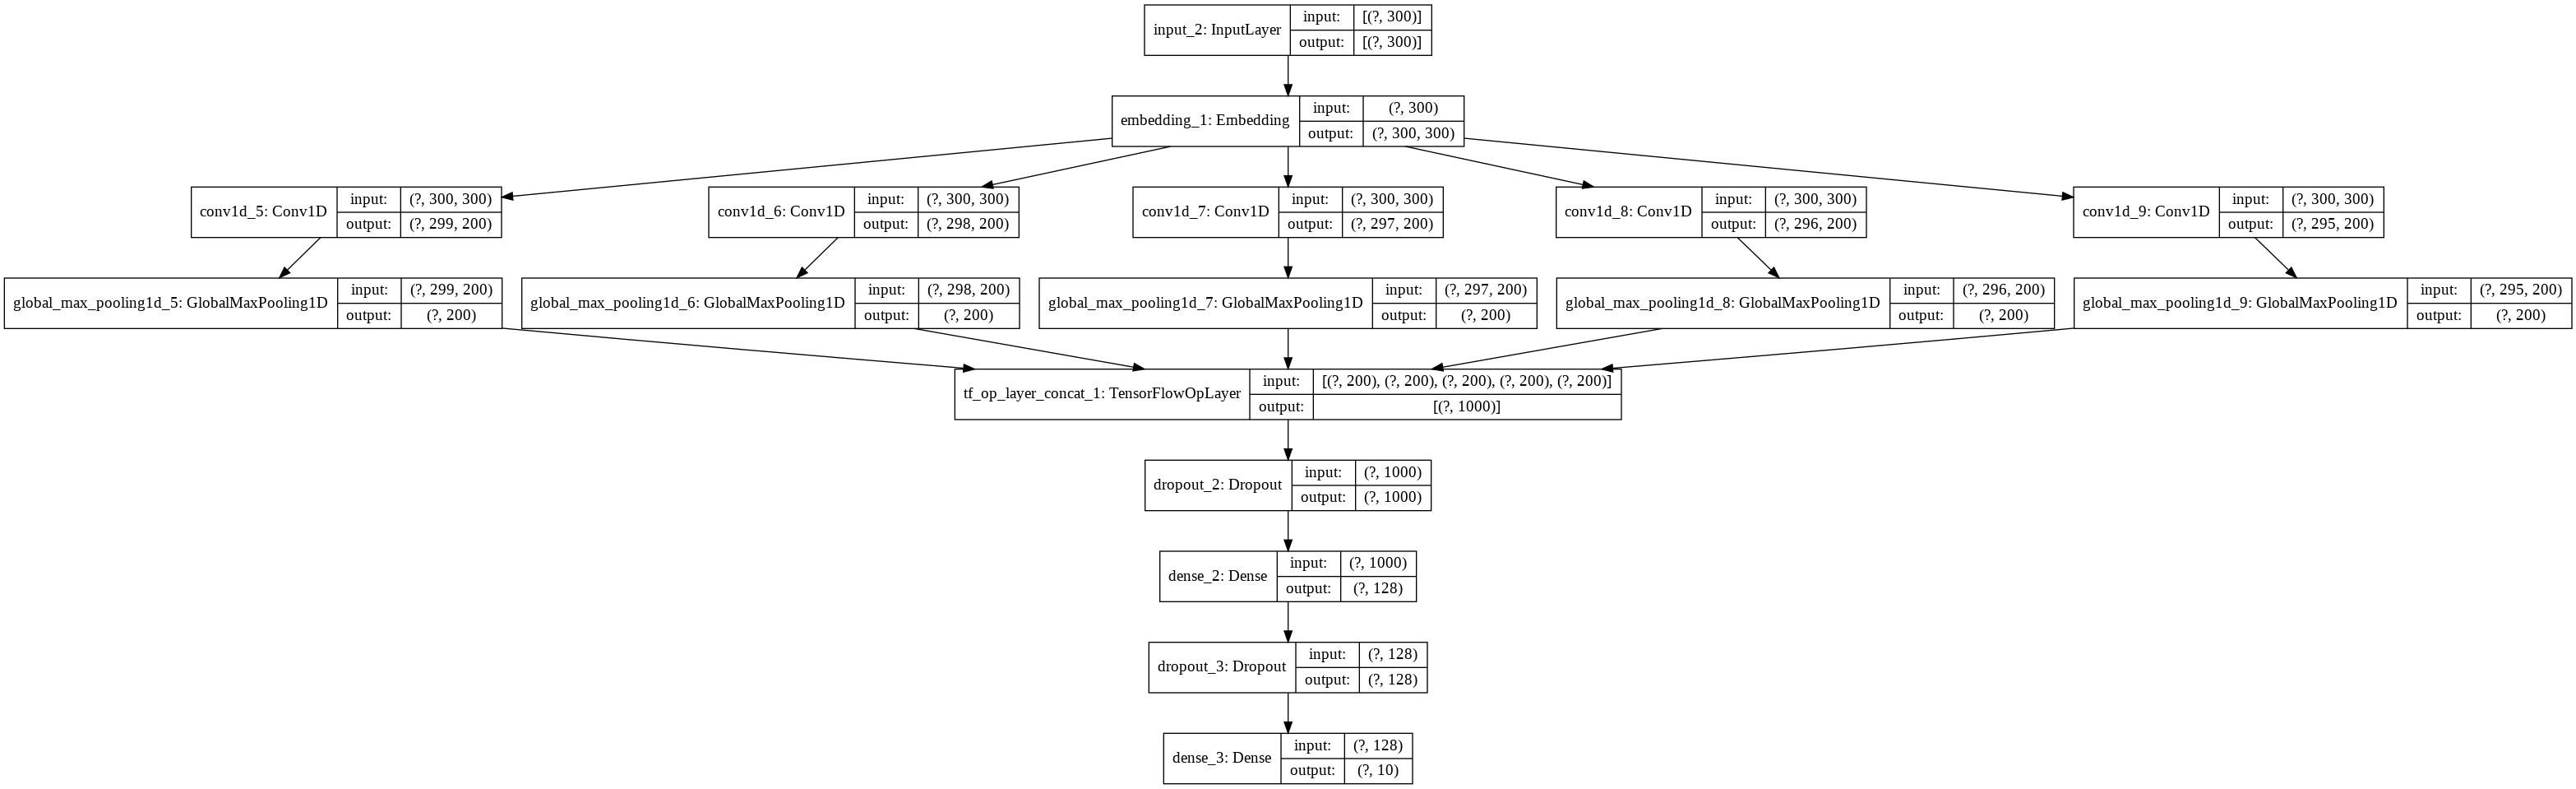

In [ ]:
plot_model(model, "my_first_model.png", show_shapes = True)

### Training Neural Network

In [ ]:
earlystop = EarlyStopping(monitor='val_acc', patience=10, min_delta=0.0001, 
                          mode = 'max')

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                            np.unique(y_train),
                                            y_train)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 2.6331365313653134,
 1: 0.3248861773811692,
 2: 2.48115438108484,
 3: 1.0625074449076832,
 4: 2.2285446595877576,
 5: 2.5161495063469674,
 6: 0.9996917904174839,
 7: 1.6719306466729147,
 8: 0.43606697628941576,
 9: 2.172898903775883}

In [ ]:
num_epochs = 100
hist = model.fit(X_train, 
                 y_train_dummy, 
                 epochs=num_epochs, 
                 validation_data = (X_test,y_test_dummy) , 
                 shuffle=True,
                 callbacks = earlystop)

Epoch 1/100
1115/1115 [==============================] - 26s 23ms/step - loss: 1.0111 - acc: 0.6679 - val_loss: 0.7334 - val_acc: 0.7549
Epoch 2/100
1115/1115 [==============================] - 26s 23ms/step - loss: 0.7530 - acc: 0.7485 - val_loss: 0.6778 - val_acc: 0.7737
Epoch 3/100
1115/1115 [==============================] - 25s 23ms/step - loss: 0.6448 - acc: 0.7824 - val_loss: 0.6199 - val_acc: 0.7919
Epoch 4/100
1115/1115 [==============================] - 25s 23ms/step - loss: 0.5598 - acc: 0.8094 - val_loss: 0.6151 - val_acc: 0.7897
Epoch 5/100
1115/1115 [==============================] - 26s 23ms/step - loss: 0.4878 - acc: 0.8328 - val_loss: 0.5935 - val_acc: 0.8001
Epoch 6/100
1115/1115 [==============================] - 26s 23ms/step - loss: 0.4322 - acc: 0.8524 - val_loss: 0.5889 - val_acc: 0.8013
Epoch 7/100
1115/1115 [==============================] - 25s 23ms/step - loss: 0.3838 - acc: 0.8691 - val_loss: 0.5988 - val_acc: 0.8059
Epoch 8/100
1115/1115 [==================

### Accuracy of Network

In [ ]:
predictions = np.argmax(hist.model.predict(X_test), axis=-1)
predictions

array([8, 1, 8, ..., 5, 8, 8])

In [ ]:
   # evaluate
loss, acc = hist.model.evaluate(X_test, y_test_dummy, verbose=0)
print('Test Accuracy: %f' % (acc*100))
print(f'MCC Score: {matthews_corrcoef(y_test_label, predictions)}')
print(f'Kappa Score: {cohen_kappa_score(y_test_label, predictions)}')

Test Accuracy: 81.266814
MCC Score: 0.7706845740165739
Kappa Score: 0.7704319460076153


### Heatmap of Neural Network

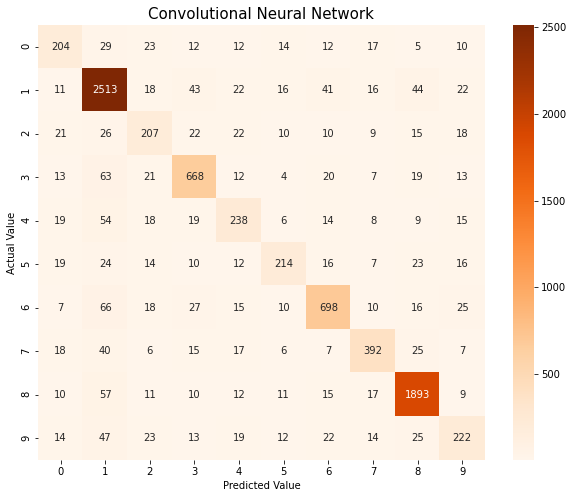

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.title('Convolutional Neural Network', fontdict = {'fontsize': 15})
ax = sns.heatmap(confusion_matrix(y_test_label, predictions), annot=True, fmt="d", cmap='Oranges')
ax.set_ylabel('Actual Value')
ax.set_xlabel('Predicted Value');

### Plotting ROC AUC Curve

### Check Misclassified Posts

In [ ]:
lb.inverse_transform(predictions)

array(['User Interface', 'Convenient App', 'User Interface', ...,
       'Recommendations', 'User Interface', 'User Interface'],
      dtype=object)

In [ ]:
# Create DataFrame with column for predicted values.
results = pd.DataFrame(lb.inverse_transform(predictions), columns=['predicted'], index = y_test.index)

# Create column for observed values.
results['actual'] = y_test
results['review'] = df['review']
results['clean_content'] = df['clean_content']

# Find all indices where predicted and true results 
# aren't the same, then save in an array.
ms_class = results[results['predicted']!= results['actual']]
ms_class.head(10)

,predicted,actual,review,clean_content
15750,Convenient App,Consumer Satisfaction,I really like that using this app is a holisti...,like app holistic experience right confirm rec...
32195,User Interface,Convenient App,Seamless and great.,seamless great
16657,User Experience,Consumer Satisfaction,Keep going your doing nice job,go nice job
13378,User Interface,Delivery,Great deals and good shipping times for most i...,great deal good shipping time item covid-19 pr...
38813,Variety & Price,User Interface,Love it! Really easy to use with a ton of litt...,love easy use ton little reward saving
38426,Variety & Price,Consumer Satisfaction,never had a bad product. been with wish for ma...,bad product year
25537,User Interface,Recommendations,Love this app so easy to find things,love app easy find thing
43488,Convenient App,Shopping Experience,items are good to buy and sellers quite reliable.,item good buy seller reliable
36766,Variety & Price,Delivery,Everything I've ordered has been exactly as I ...,order exactly except
6519,Convenient App,In-App Actitives,The most user friendly platform. Easy and simp...,user friendly platform easy simple reward syst...


In [ ]:
# save model and architecture to single file
model.save('/content/drive/My Drive/Colab Notebooks/2.model.h5')
print('Saved model to disk')

Saved model to disk


In [ ]:
from keras.models import load_model
 
# load model
model = load_model('/content/drive/My Drive/Colab Notebooks/2.model.h5')
# summarize model.
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 300)     2863500     input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 299, 200)     120200      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 298, 200)     180200      embedding_1[0][0]                
_______________________________________________________________________________________

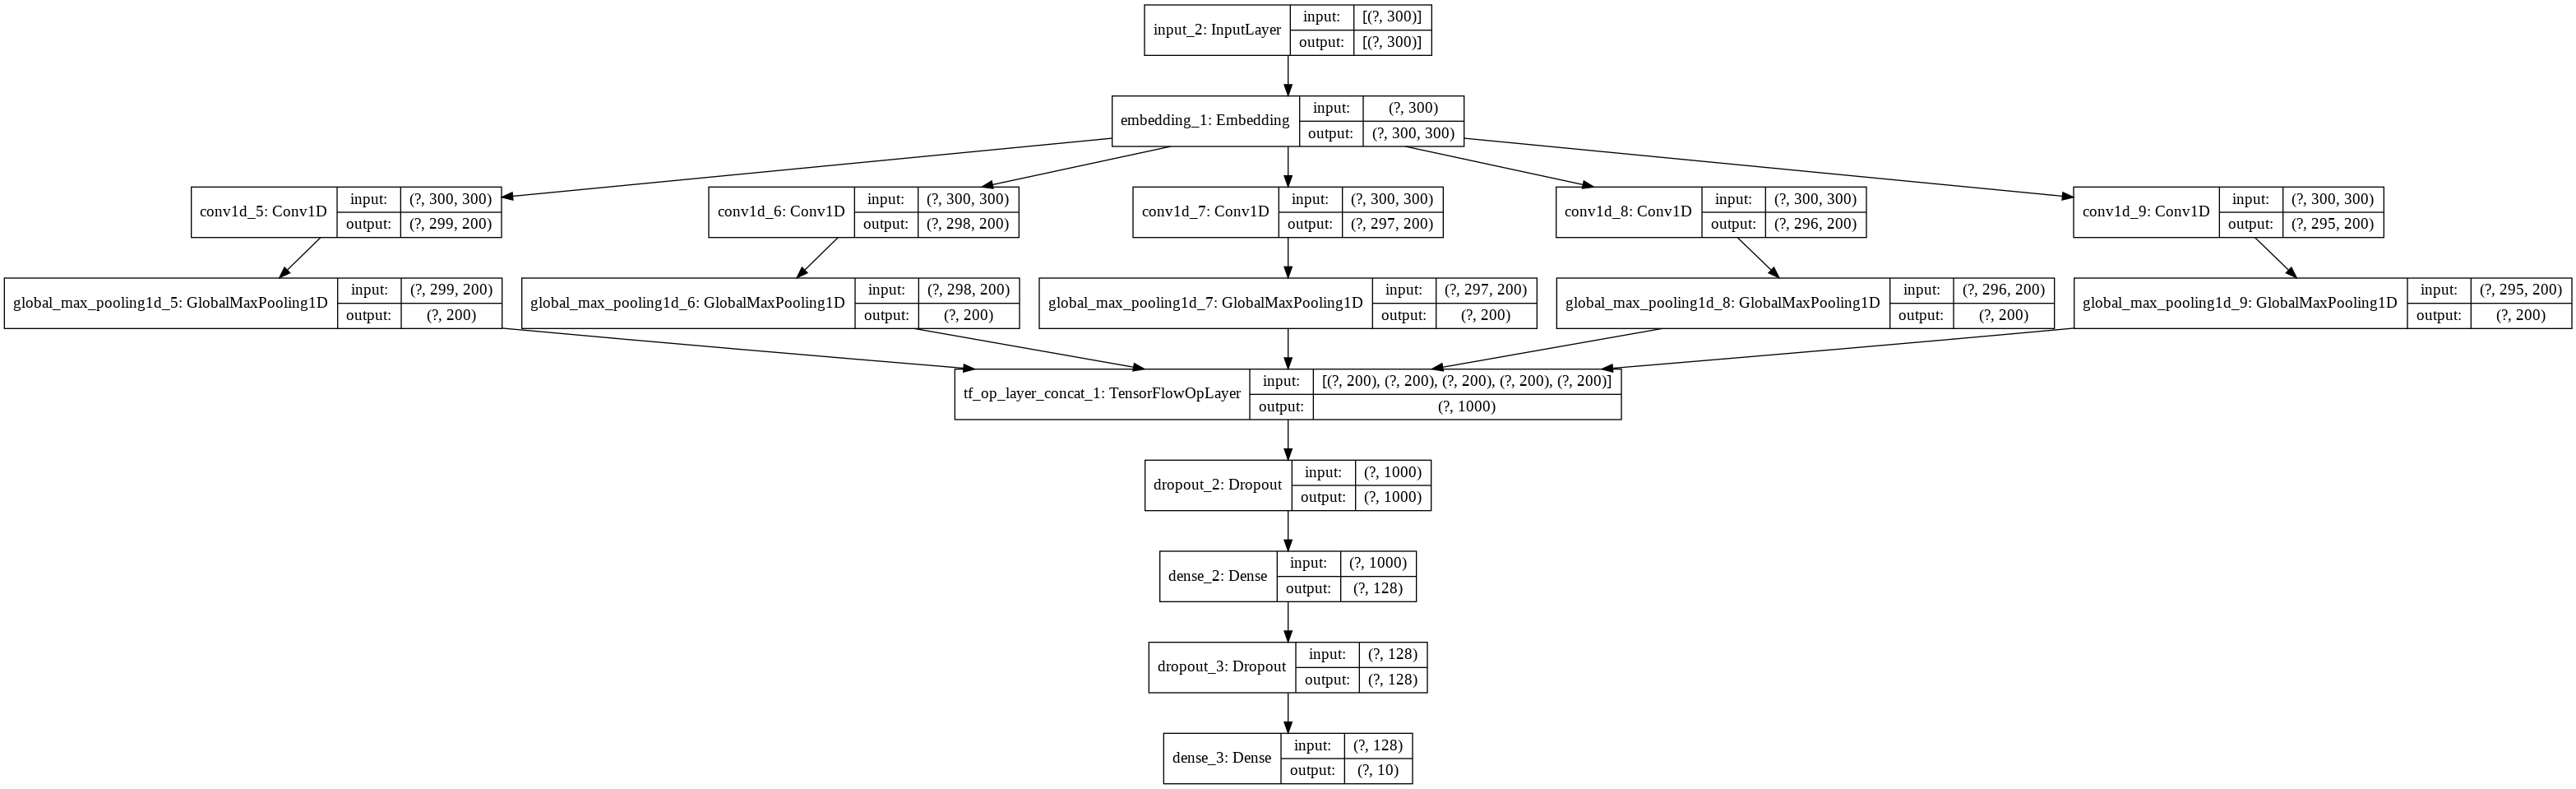

In [ ]:
plot_model(model, "my_first_model.png", show_shapes = True)